# General DA fittings and Fokker-Planck comparisons with lmfit(Hénon map with octupolar kick $\mu$)

## Imports

In [2]:
%load_ext autoreload

In [3]:
%autoreload

In [1]:
%matplotlib widget

In [1]:
# Base libraries
import math
import numpy as np
import scipy.integrate as integrate
from scipy.special import erf
import pickle
import itertools
from scipy.optimize import curve_fit

from numba import njit, prange

from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from math import gcd

import pandas as pd

from scipy.special import lambertw
from scipy.interpolate import interp1d

import os
import re

# Personal libraries
import sixtrackwrap as sx
import crank_nicolson_numba.nekhoroshev as nk
import henon_map as hm

# Personal modules
import fit_utils as fit

# Lmfit
from lmfit import Minimizer, Parameters, report_fit

# Let's get freaky
import multiprocessing

Sixtracklib module not found! Loading dummy functions!


/home/STUDENTI/carlo.montanari3/loss_studies/notebooks/fit_utils.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


*if we want quiet operations... even though it's not a good practice at all...*

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
PROCESSES = 32

In [4]:
def wrap_fit(f, turn, da, eps, mu):
    for i in range(20):
        try:
            r1, r2 = f(turn, da)
        except ValueError:
            continue
        else:
            return r1, r2, eps, mu
    raise ValueError

def wrap_fp_fit(f, turn, loss, I0, I_max, k, eps, mu):
    r1, r2 = f(turn, loss, 1.0, I0, I_max, 1, k, 0.26, "lstsqr")
    return r1, r2, eps, mu

In [5]:
def chi2(est, original):
    return np.sum(np.power((est - original)/original, 2))

## Load data and setup original DA

In [6]:
savepath = "../data/"

sigma = 0.15
turn_samples = 500
min_turns = 1000
max_turns = 5000000
turn_sampling = np.linspace(min_turns, max_turns, turn_samples, dtype=np.int)[::-1]
# Do we want to load ALL the Hénon data files or should we skip some?
skipper = 1

cut_point = 0.9

def sorterer(s):
    ints = re.findall(r'-?\d+', s)
    value = int(ints[0]) * 1000 + int(ints[1]) + 500
    return value

files = list(sorted(list(filter(lambda f: "henon_bis_eps_" in f and "unif" not in f and "hdf5" in f and "mu" in f, os.listdir(savepath))), key=sorterer))[::skipper]

In [7]:
epsilons = []
mus = []

real_DAs = []
real_DAs_err = []
gaussian_DAs = []

real_losses = []
gaussian_losses = []

In [8]:
def callback(results):
    epsilons.append(results[0])
    mus.append(results[1])
    real_DAs.append(results[2])
    real_DAs_err.append(results[3])
    d_r = results[4]
    gaussian_losses.append(results[5])
    print(results[0], results[1])
    
def preprocess(f):
    ints = re.findall(r'-?\d+', f)
    epsilon = float(ints[0])
    mu = int(ints[1])
    
    if mu == 87:
        mu = 87.5
    elif mu == -87:
        mu = -87.5
    elif mu == 62:
        mu = 62.5
    elif mu == -62:
        mu = -62.5
    elif mu == 37:
        mu = 37.5
    elif mu == -37:
        mu = -37.5
    elif mu == 12:
        mu = 12.5
    elif mu == -12:
        mu = -12.5
    mu = mu / 100
    
    epsilons.append(epsilon)
    engine = hm.uniform_radial_scanner(savepath + f)
    #print(epsilon)
    d_r = engine.dr
    DA, DA_err = engine.compute_DA_standard(turn_sampling)
    #print(epsilon, "Done DA")
    engine.assign_weights_from_file(savepath + "weights_mu.hdf5")
    loss = engine.compute_loss(turn_sampling, cut_point, True)
    #print(epsilon, "Done Loss")
    return(epsilon, mu, DA, DA_err, d_r, loss)

In [9]:
e = hm.uniform_radial_scanner(savepath + files[0])
e.create_weights_in_dataset(savepath + "weights_mu.hdf5", hm.assign_symmetric_gaussian(sigma))
del e

assigning weights: 100%|██████████| 100/100 [00:02<00:00, 35.64it/s]


In [ ]:
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(preprocess, args=(f,), callback=callback) for f in files[:]]
    pool.close()
    pool.join()
    
TMP = sorted(zip(epsilons, mus, real_DAs, real_DAs_err, gaussian_losses), key=lambda x: x[0] * 1000 + x[1])

epsilons = [T[0] for T in TMP]
mus = [T[1] for T in TMP]
real_DAs = [T[2] for T in TMP]
real_DAs_err = [T[3] for T in TMP]
gaussian_losses = [T[4] for T in TMP]

epsilon_set = set(epsilons)
mu_set = set(mus)

2.0 0.625
4.0 0.5
4.0 -0.25
2.0 0.5
4.0 0.625
2.0 -0.25
2.0 0.375
2.0 0.25
4.0 0.0
2.0 -0.5
4.0 -1.0
4.0 1.0
4.0 -0.375
6.0 -0.5
4.0 -0.75
4.0 0.25
2.0 -1.0
2.0 -0.75
2.0 -0.375
4.0 0.75
2.0 0.875
4.0 0.875
4.0 -0.625
2.0 0.75
2.0 -0.625
4.0 -0.5
6.0 -0.75
6.0 -0.625
4.0 0.375
2.0 0.0
2.0 1.0
6.0 -1.0
6.0 -0.375
6.0 0.0
6.0 0.25
6.0 0.375
6.0 0.625
6.0 -0.25
6.0 0.75
8.0 -0.25
8.0 -1.0
8.0 0.0
6.0 0.875
6.0 1.0
8.0 -0.75
8.0 -0.375
8.0 -0.625
8.0 -0.5
8.0 0.875
8.0 0.625
8.0 0.5
8.0 0.375
10.0 -0.375
10.0 -0.75
10.0 -1.0
10.0 -0.25
8.0 1.0
8.0 0.75
10.0 -0.5
10.0 -0.625
6.0 0.5
10.0 0.25
10.0 0.0
8.0 0.25


### Save data (since it takes a long time to generate)

In [ ]:
with open("../data/octo_henon_loss_data.pkl", "wb") as f:
    pickle.dump(
        {
            "sigma": sigma,
            "turn_samples": turn_samples,
            "min_turns": min_turns,
            "max_turns": max_turns,
            "epsilons": epsilons,
            "mus": mus,
            "epsilon_set": epsilon_set,
            "mu_set": mu_set,
            "real_losses": real_losses,
            "gaussian_losses": gaussian_losses,
            "real_DAs": real_DAs,
            "real_DAs_err": real_DAs_err,
            "gaussian_DAs": gaussian_DAs
        },
        f
    )

### Load data (if it was already computed before)

In [ ]:
with open("../data/octo_henon_loss_data.pkl", "rb") as f:
    dictionary = pickle.load(f)
    sigma = dictionary["sigma"]
    turn_samples = dictionary["turn_samples"]
    min_turns = dictionary["min_turns"]
    max_turns = dictionary["max_turns"]
    epsilons = dictionary["epsilons"]
    mus = dictionary["mus"]
    epsilon_set = dictionary["epsilon_set"]
    mu_set = dictionary["mu_set"]
    real_losses = dictionary["real_losses"]
    gaussian_losses = dictionary["gaussian_losses"]
    real_DAs = dictionary["real_DAs"]
    real_DAs_err = dictionary["real_DAs_err"]
    gaussian_DAs = dictionary["gaussian_DAs"]

fix a bit the format...

In [ ]:
epsilons = np.asarray(epsilons)
mus = np.asarray(mus)

## Visualize the various DA and Loss plots

In [ ]:
for mu in mu_set:
    plt.figure()
    cmap = matplotlib.cm.get_cmap('viridis')
    index = np.linspace(0, 1, len(epsilon_set))
    j = 0
    for i in range(len(gaussian_losses)):
        if mus[i] == mu:
            plt.plot(turn_sampling, gaussian_losses[i], c=cmap(index[j]))
            j += 1
    plt.xlabel("$N$ turns")
    plt.ylabel("active beam")
    plt.title("Loss for varying $\\epsilon$, $\\mu={}$".format(mu))
    plt.savefig("../img/octo_loss_mu_{}.png".format(mu), dpi=600)

In [ ]:
for mu in mu_set:
    plt.figure()
    cmap = matplotlib.cm.get_cmap('viridis')
    index = np.linspace(0, 1, len(epsilon_set))
    j = 0
    for i in range(len(gaussian_losses)):
        if mus[i] == mu:
            plt.plot(turn_sampling, real_DAs[i], c=cmap(index[j]))
            j += 1
    plt.xlabel("$N$ turns")
    plt.ylabel("DA")
    plt.title("DA for varying $\\epsilon$, $\\mu={}$".format(mu))
    plt.savefig("../img/octo_DA_mu_{}.png".format(mu), dpi=600)

## General fitting of all the Hénon maps across all models

In [ ]:
real_results_model_2 = []
real_finals_model_2 = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit.fit_model_2, turn_sampling[::-1], real_DAs[i][::-1], epsilons[i], mus[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

real_results_model_2 = [T[2] for T in TMP]
real_finals_model_2 = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_2.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_2,
        real_finals_model_2,
    ), f)

In [ ]:
with open("../data/octo_henon_fit_2.pkl", 'rb') as f:
    real_results_model_2, real_finals_model_2 = pickle.load(f)

In [ ]:
k1 = []
k1_err = []
n0_1 = []
n0_1_err = [] 
rho1 = []
rho1_err = []

chi_1 = []
rchi_1 = []

for i, eps in enumerate(epsilons):
    k1.append(real_results_model_2[i].params.get("k").value)
    k1_err.append(real_results_model_2[i].params.get("k").stderr)
    n0_1.append(real_results_model_2[i].params.get("n0").value)
    n0_1_err.append(real_results_model_2[i].params.get("n0").stderr)
    rho1.append(real_results_model_2[i].params.get("rho").value)
    rho1_err.append(real_results_model_2[i].params.get("rho").stderr)
    chi_1.append(real_results_model_2[i].chisqr)
    rchi_1.append(real_results_model_2[i].redchi)

k1 = np.asarray(k1)
k1_err = np.asarray(k1_err)
rho1 = np.asarray(rho1)
rho1_err = np.asarray(rho1_err)
n0_1 = np.asarray(n0_1)
n0_1_err = np.asarray(n0_1_err)
chi_1 = np.asarray(chi_1)
rchi_1 = np.asarray(rchi_1)

In [ ]:
# Lmfit
from lmfit import Minimizer, Parameters, report_fit

def fit_model_2_fixed_n0(turns, DA):
    params = Parameters()
    params.add("rho", value=1, min=0, vary=True)
    params.add("n0", value=1, vary=False)
    params.add("k", value=1, min=0, vary=True)
    minner = Minimizer(fit.model_2_lmfit, params, fcn_args=(turns, DA))
    result = minner.minimize(method="basinhopping")
    final = DA + result.residual
    return result, final

In [ ]:
real_results_model_2_fixed_n0 = []
real_finals_model_2_fixed_n0 = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit_model_2_fixed_n0, turn_sampling[::-1], real_DAs[i][::-1], epsilons[i], mus[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

real_results_model_2_fixed_n0 = [T[2] for T in TMP]
real_finals_model_2_fixed_n0 = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_2_fix.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_2_fixed_n0,
        real_finals_model_2_fixed_n0,
    ), f)

In [ ]:
with open("../data/octo_henon_fit_2_fix.pkl", 'rb') as f:
    real_results_model_2_fixed_n0, real_finals_model_2_fixed_n0 = pickle.load(f)

In [ ]:
k1_fix = []
k1_err_fix = []
rho1_fix = []
rho1_err_fix = []

chi_1_fix = []
rchi_1_fix = []

for i, eps in enumerate(epsilons):
    k1_fix.append(real_results_model_2_fixed_n0[i].params.get("k").value)
    k1_err_fix.append(real_results_model_2_fixed_n0[i].params.get("k").stderr)
    rho1_fix.append(real_results_model_2_fixed_n0[i].params.get("rho").value)
    rho1_err_fix.append(real_results_model_2_fixed_n0[i].params.get("rho").stderr)
    chi_1_fix.append(real_results_model_2_fixed_n0[i].chisqr)
    rchi_1_fix.append(real_results_model_2_fixed_n0[i].redchi)

k1_fix = np.asarray(k1_fix)
k1_err_fix = np.asarray(k1_err_fix)
rho1_fix = np.asarray(rho1_fix)
rho1_err_fix = np.asarray(rho1_err_fix)
chi_1_fix = np.asarray(chi_1_fix)
rchi_1_fix = np.asarray(rchi_1_fix)

In [ ]:
real_results_model_4 = []
real_finals_model_4 = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit.fit_model_4, turn_sampling[::-1], real_DAs[i][::-1], epsilons[i], mus[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

real_results_model_4 = [T[2] for T in TMP]
real_finals_model_4 = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_4.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_4,
        real_finals_model_4,
    ), f)

In [ ]:
with open("../data/octo_henon_fit_4.pkl", 'rb') as f:
    real_results_model_4, real_finals_model_4 = pickle.load(f)

In [ ]:
k2 = []
k2_err = []
rho2 = []
rho2_err = []

chi_2 = []
rchi_2 = []

for i, eps in enumerate(epsilons):
    k2.append(real_results_model_4[i].params.get("k").value)
    k2_err.append(real_results_model_4[i].params.get("k").stderr)
    rho2.append(real_results_model_4[i].params.get("rho").value)
    rho2_err.append(real_results_model_4[i].params.get("rho").stderr)
    chi_2.append(real_results_model_4[i].chisqr)
    rchi_2.append(real_results_model_4[i].redchi)

k2 = np.asarray(k2)
k2_err = np.asarray(k2_err)
rho2 = np.asarray(rho2)
rho2_err = np.asarray(rho2_err)
chi_2 = np.asarray(chi_2)
rchi_2 = np.asarray(rchi_2)

In [ ]:
real_results_model_4_free = []
real_finals_model_4_free = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit.fit_model_4_free, turn_sampling[::-1], real_DAs[i][::-1], epsilons[i], mus[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

real_results_model_4_free = [T[2] for T in TMP]
real_finals_model_4_free = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_4_free.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_4_free,
        real_finals_model_4_free,
    ), f)

In [ ]:
with open("../data/octo_henon_fit_4_free.pkl", 'rb') as f:
    real_results_model_4_free, real_finals_model_4_free = pickle.load(f)

In [ ]:
k3 = []
k3_err = []
rho3 = []
rho3_err = []
n0_3 = []
n0_3_err = []

chi_3 = []
rchi_3 = []

for i, eps in enumerate(epsilons):
    k3.append(real_results_model_4_free[i].params.get("k").value)
    k3_err.append(real_results_model_4_free[i].params.get("k").stderr)
    rho3.append(real_results_model_4_free[i].params.get("rho").value)
    rho3_err.append(real_results_model_4_free[i].params.get("rho").stderr)
    n0_3.append(real_results_model_4_free[i].params.get("n0").value)
    n0_3_err.append(real_results_model_4_free[i].params.get("n0").stderr)
    chi_3.append(real_results_model_4_free[i].chisqr)
    rchi_3.append(real_results_model_4_free[i].redchi)

k3 = np.asarray(k3)
k3_err = np.asarray(k3_err)
rho3 = np.asarray(rho3)
rho3_err = np.asarray(rho3_err)
n0_3 = np.asarray(n0_3)
n0_3_err = np.asarray(n0_3_err)
chi_3 = np.asarray(chi_3)
rchi_3 = np.asarray(rchi_3)

In [ ]:
for i, mu in enumerate(mu_set):
    plt.figure()
    plt.errorbar(epsilons[mus == mu], rho1_fix[mus == mu], yerr=rho1_err_fix[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 2, two parameters")
    plt.errorbar(epsilons[mus == mu], rho1[mus == mu], yerr=rho1_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 2, three parameters")
    plt.errorbar(epsilons[mus == mu], rho2[mus == mu], yerr=rho2_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 4, two parameters")
    plt.errorbar(epsilons[mus == mu], rho3[mus == mu], yerr=rho3_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 4, three parameters")

    plt.yscale("log")

    plt.legend()
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\rho$")
    plt.title("Hénon map fitting results for different $\\epsilon$ values $(\\mu={})$".format(mu))
    plt.tight_layout()
    plt.savefig("../img/octo_rho_values_henon_err_mu_{}.png".format(mu), dpi=600)

In [ ]:
for i, epsilon in enumerate(epsilon_set):
    plt.figure()
    plt.errorbar(mus[epsilons == epsilon], rho1_fix[epsilons == epsilon], yerr=rho1_err_fix[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 2, two parameters")
    plt.errorbar(mus[epsilons == epsilon], rho1[epsilons == epsilon], yerr=rho1_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 2, three parameters")
    plt.errorbar(mus[epsilons == epsilon], rho2[epsilons == epsilon], yerr=rho2_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 4, two parameters")
    plt.errorbar(mus[epsilons == epsilon], rho3[epsilons == epsilon], yerr=rho3_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 4, three parameters")

    plt.yscale("log")

    plt.legend()
    plt.xlabel("$\\mu$")
    plt.ylabel("$\\rho$")
    plt.title("Hénon map fitting results for different $\\mu$ values $(\\varepsilon={})$".format(epsilon))
    plt.tight_layout()
    plt.savefig("../img/octo_rho_values_henon_err_eps_{}.png".format(epsilon), dpi=600)

In [ ]:
for i, mu in enumerate(mu_set):
    plt.figure()
    plt.errorbar(epsilons[mus == mu], k1_fix[mus == mu], yerr=k1_err_fix[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 2, two parameters")
    plt.errorbar(epsilons[mus == mu], k1[mus == mu], yerr=k1_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 2, three parameters")
    plt.errorbar(epsilons[mus == mu], k2[mus == mu], yerr=k2_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 4, two parameters")
    plt.errorbar(epsilons[mus == mu], k3[mus == mu], yerr=k3_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 4, three parameters")

    plt.legend()
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\kappa$")
    plt.title("Hénon map fitting results for different $\\epsilon$ values $(\\mu={})$".format(mu))
    plt.tight_layout()
    plt.savefig("../img/octo_k_values_henon_err_mu_{}.png".format(mu), dpi=600)

In [ ]:
for i, epsilon in enumerate(epsilon_set):
    plt.figure()
    plt.errorbar(mus[epsilons == epsilon], k1_fix[epsilons == epsilon], yerr=k1_err_fix[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 2, two parameters")
    plt.errorbar(mus[epsilons == epsilon], k1[epsilons == epsilon], yerr=k1_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 2, three parameters")
    plt.errorbar(mus[epsilons == epsilon], k2[epsilons == epsilon], yerr=k2_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 4, two parameters")
    plt.errorbar(mus[epsilons == epsilon], k3[epsilons == epsilon], yerr=k3_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 4, three parameters")

    plt.legend()
    plt.xlabel("$\\mu$")
    plt.ylabel("$k$")
    plt.title("Hénon map fitting results for different $\\mu$ values $(\\varepsilon={})$".format(epsilon))
    plt.tight_layout()
    plt.savefig("../img/octo_k_values_henon_err_eps_{}.png".format(epsilon), dpi=600)

In [ ]:
for i in tqdm(range(len(epsilons))):
    plt.figure()
    plt.plot(turn_sampling[::], real_DAs[i], label="DA")
    plt.plot(turn_sampling[::-1], real_finals_model_2[i], label="model 2, 3 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_2_fixed_n0[i], label="model 2, 2 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_4[i], label="model 4, 2 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_4_free[i], label="model 4, 3 pars")
    
    plt.xlabel("$N$ turns")
    plt.ylabel("$DA$")
    
    plt.xscale("log")
    
    plt.legend(fontsize="x-small")
    plt.title("$\\varepsilon={}, \\mu={}$".format(epsilons[i], mus[i]))
    plt.savefig("../img/octo_henon_da_fit_log_eps_{}_mu_{}.png".format(epsilons[i], mus[i]), dpi=600)


In [ ]:
for i in tqdm(range(len(epsilons))):
    plt.figure()
    plt.plot(turn_sampling[::], real_DAs[i], label="DA")
    plt.plot(turn_sampling[::-1], real_finals_model_2[i], label="model 2, 3 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_2_fixed_n0[i], label="model 2, 2 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_4[i], label="model 4, 2 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_4_free[i], label="model 4, 3 pars")
    
    plt.xlabel("$N$ turns")
    plt.ylabel("$DA$")
        
    plt.legend(fontsize="x-small")
    plt.title("$\\varepsilon={}, \\mu={}$".format(epsilons[i], mus[i]))
    plt.savefig("../img/octo_henon_da_fit_eps_{}_mu_{}.png".format(epsilons[i], mus[i]), dpi=600)


### New fitting models

In [ ]:
def model_2_bis(params, x, data):
    b_tilde = params["b_tilde"]
    B = params["B"]
    N_0 = params["N_0"]
    k = params["k"]
    temp = np.power(B * np.log(x / N_0), k)
    temp[np.isnan(temp)] = 0.0
    model = b_tilde / temp
    if np.any(np.isnan(model)):
        print(b_tilde, B, N_0, k)
    return model - data

def model_4_bis(params, x, data):
    b_tilde = params["b_tilde"]
    B = params["B"]
    N_0 = params["N_0"]
    k = params["k"]
    lambert = lambertw(
        -(2 / (k * B)) * np.power(x / N_0, - 2 / k), -1
    )
    lambert[np.isnan(lambert)] = -np.inf
    model = b_tilde / np.power(- (k * B / 2) * np.real(lambert), k)
    
    if np.any(np.isnan(model)):
        print(b_tilde, B, N_0, k)
        try:
            print(params["delta"])
        except:
            pass
    #print(model)
    return model - data

In [ ]:
def fit_model_2_bis(turns, DA):
    params = Parameters()
    params.add("b_tilde", value=1, min=0, vary=True)
    params.add("B", value=1, min=0, vary=True)
    params.add("N_0", expr="7 * sqrt(6) / 48 * (b_tilde ** (1/2))")
    params.add("k", value=1, min=0, vary=True)
    minner = Minimizer(model_2_bis, params, fcn_args=(turns, DA))
    result = minner.minimize(method="basinhopping")
    final = DA + result.residual
    return result, final

def fit_model_2_bis_free(turns, DA):
    params = Parameters()
    params.add("b_tilde", value=1, min=0, vary=True)
    params.add("B", value=1, min=0, vary=True)
    params.add("N_0", value=1, min=0, max=turns.min() * 1.0, vary=True)
    params.add("k", value=1, min=0, vary=True)
    minner = Minimizer(model_2_bis, params, fcn_args=(turns, DA))
    result = minner.minimize(method="basinhopping")
    final = DA + result.residual
    return result, final

def fit_model_4_bis(turns, DA):
    params = Parameters()
    params.add("b_tilde", value=1, min=0, vary=True)
    params.add("delta", value=0.2, min=0.0, max=1/np.e, vary=True)
    params.add("N_0", expr="7 * sqrt(6) / 48 * (b_tilde ** (1/2))")
    params.add("k", value=0.5, min=0.1, max=3, vary=True)
    params.add("B", expr="(2/(k*delta)) * (1000 / N_0) ** (-2/k)")
    minner = Minimizer(model_4_bis, params, fcn_args=(turns, DA))
    result = minner.minimize(method="basinhopping")
    final = DA + result.residual
    return result, final

def fit_model_4_bis_free(turns, DA):
    params = Parameters()
    params.add("b_tilde", value=1, min=0, vary=True)
    params.add("delta", value=0.2, min=0.0, max=1/np.e, vary=True)
    params.add("N_0", value=1, min=0, max=turns.min() * 1.0, vary=True)
    params.add("k", value=0.5, min=0.1, max=3, vary=True)
    params.add("B", expr="(2/(k*delta)) * (1000 / N_0) ** (-2/k)")
    minner = Minimizer(model_4_bis, params, fcn_args=(turns, DA))
    result = minner.minimize(method="basinhopping")
    final = DA + result.residual
    return result, final

In [ ]:
real_results_model_2_bis = []
real_finals_model_2_bis = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit_model_2_bis, turn_sampling[::-1], real_DAs[i][::-1], epsilons[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_result, temp_final), key=lambda x: x[0])

real_results_model_2_bis = [T[1] for T in TMP]
real_finals_model_2_bis = [T[2] for T in TMP]

In [ ]:
for i, eps in tqdm(list(enumerate(epsilons))):
    turns = turn_sampling[::-1]
    real_DA = real_DAs[i][::-1]
    
    result, final = fit_model_2_bis(turns, real_DA)
    real_results_model_2_bis.append(result)
    real_finals_model_2_bis.append(final)

In [ ]:
with open("../data/octo_henon_fit_2_new.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_2_bis,
        real_finals_model_2_bis
    ), f)

In [ ]:
with open("../data/octo_henon_fit_2_new.pkl", 'rb') as f:
    real_results_model_2_bis, real_finals_model_2_bis = pickle.load(f)

In [ ]:
k4 = []
k4_err = []
b_tilde4 = []
b_tilde4_err = []
B4 = []
B4_err = []
N_0_4 = []
N_0_4_err = []

chi_4 = []
rchi_4 = []

for i, eps in enumerate(epsilons):
    k4.append(real_results_model_2_bis[i].params.get("k").value)
    k4_err.append(real_results_model_2_bis[i].params.get("k").stderr)
    b_tilde4.append(real_results_model_2_bis[i].params.get("b_tilde").value)
    b_tilde4_err.append(real_results_model_2_bis[i].params.get("b_tilde").stderr)
    B4.append(real_results_model_2_bis[i].params.get("B").value)
    B4_err.append(real_results_model_2_bis[i].params.get("B").stderr)
    N_0_4.append(real_results_model_2_bis[i].params.get("N_0").value)
    N_0_4_err.append(real_results_model_2_bis[i].params.get("N_0").stderr)
    chi_4.append(real_results_model_2_bis[i].chisqr)
    rchi_4.append(real_results_model_2_bis[i].redchi)
    

In [ ]:
real_results_model_4_bis = []
real_finals_model_4_bis = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit_model_4_bis, turn_sampling[::-1], real_DAs[i][::-1], epsilons[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_result, temp_final), key=lambda x: x[0])

real_results_model_4_bis = [T[1] for T in TMP]
real_finals_model_4_bis = [T[2] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_4_new.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_4_bis,
        real_finals_model_4_bis
    ), f)

In [ ]:
with open("../data/octo_henon_fit_4_new.pkl", 'rb') as f:
    real_results_model_4_bis, real_finals_model_4_bis = pickle.load(f)

In [ ]:
k5 = []
k5_err = []
b_tilde5 = []
b_tilde5_err = []
B5 = []
B5_err = []
N_0_5 = []
N_0_5_err = []

chi_5 = []
rchi_5 = []

for i, eps in enumerate(epsilons):
    k5.append(real_results_model_4_bis[i].params.get("k").value)
    k5_err.append(real_results_model_4_bis[i].params.get("k").stderr)
    b_tilde5.append(real_results_model_4_bis[i].params.get("b_tilde").value)
    b_tilde5_err.append(real_results_model_4_bis[i].params.get("b_tilde").stderr)
    B5.append(real_results_model_4_bis[i].params.get("B").value)
    B5_err.append(real_results_model_4_bis[i].params.get("B").stderr)
    N_0_5.append(real_results_model_4_bis[i].params.get("N_0").value)
    N_0_5_err.append(real_results_model_4_bis[i].params.get("N_0").stderr)
    chi_5.append(real_results_model_4_bis[i].chisqr)
    rchi_5.append(real_results_model_4_bis[i].redchi)
    

In [ ]:
real_results_model_2_bis_free = []
real_finals_model_2_bis_free = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit_model_2_bis_free, turn_sampling[::-1], real_DAs[i][::-1], epsilons[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_result, temp_final), key=lambda x: x[0])

real_results_model_2_bis_free = [T[1] for T in TMP]
real_finals_model_2_bis_free = [T[2] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_2_new_free.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_2_bis_free,
        real_finals_model_2_bis_free
    ), f)

In [ ]:
with open("../data/octo_henon_fit_2_new_free.pkl", 'rb') as f:
    real_results_model_2_bis_free, real_finals_model_2_bis_free = pickle.load(f)

In [ ]:
k6 = []
k6_err = []
b_tilde6 = []
b_tilde6_err = []
B6 = []
B6_err = []
N_0_6 = []
N_0_6_err = []

chi_6 = []
rchi_6 = []

for i, eps in enumerate(epsilons):
    k6.append(real_results_model_2_bis_free[i].params.get("k").value)
    k6_err.append(real_results_model_2_bis_free[i].params.get("k").stderr)
    b_tilde6.append(real_results_model_2_bis_free[i].params.get("b_tilde").value)
    b_tilde6_err.append(real_results_model_2_bis_free[i].params.get("b_tilde").stderr)
    B6.append(real_results_model_2_bis_free[i].params.get("B").value)
    B6_err.append(real_results_model_2_bis_free[i].params.get("B").stderr)
    N_0_6.append(real_results_model_2_bis_free[i].params.get("N_0").value)
    N_0_6_err.append(real_results_model_2_bis_free[i].params.get("N_0").stderr)
    chi_6.append(real_results_model_2_bis_free[i].chisqr)
    rchi_6.append(real_results_model_2_bis_free[i].redchi)
    

In [ ]:
real_results_model_4_bis_free = []
real_finals_model_4_bis_free = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit_model_4_bis_free, turn_sampling[::-1], real_DAs[i][::-1], epsilons[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_result, temp_eps), key=lambda x: x[0])

real_results_model_4_bis_free = [T[1] for T in TMP]
real_finals_model_4_bis_free = [T[2] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_4_new_free.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_4_bis_free,
        real_finals_model_4_bis_free
    ), f)

In [ ]:
with open("../data/octo_henonocto_henon_fit_4_new_free.pkl", 'rb') as f:
    real_results_model_4_bis_free, real_finals_model_4_bis_free = pickle.load(f)

In [ ]:
k7 = []
k7_err = []
b_tilde7 = []
b_tilde7_err = []
B7 = []
B7_err = []
N_0_7 = []
N_0_7_err = []

chi_7 = []
rchi_7 = []

for i, eps in enumerate(epsilons):
    k7.append(real_results_model_4_bis_free[i].params.get("k").value)
    k7_err.append(real_results_model_4_bis_free[i].params.get("k").stderr)
    b_tilde7.append(real_results_model_4_bis_free[i].params.get("b_tilde").value)
    b_tilde7_err.append(real_results_model_4_bis_free[i].params.get("b_tilde").stderr)
    B7.append(real_results_model_4_bis_free[i].params.get("B").value)
    B7_err.append(real_results_model_4_bis_free[i].params.get("B").stderr)
    N_0_7.append(real_results_model_4_bis_free[i].params.get("N_0").value)
    N_0_7_err.append(real_results_model_4_bis_free[i].params.get("N_0").stderr)
    chi_7.append(real_results_model_4_bis_free[i].chisqr)
    rchi_7.append(real_results_model_4_bis_free[i].redchi)
    

NameError: name 'chi_4' is not defined

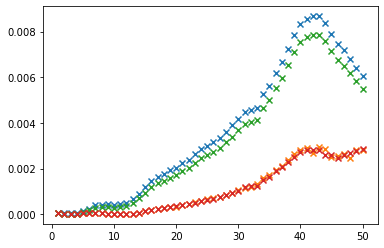

In [52]:
plt.figure()

plt.scatter(epsilons, chi_1_fix, marker="x", label="Model 2, two parameters")
plt.scatter(epsilons, chi_1, marker="x", label="Model 2, three parameters")
plt.scatter(epsilons, chi_2, marker="x", label="Model 4, two parameters")
plt.scatter(epsilons, chi_3, marker="x", label="Model 4, three parameters")
plt.scatter(epsilons, chi_4, marker="x", label="Model 2 new, n0 fixed")
#plt.scatter(epsilons, chi_5, marker="x", label="Model 4 new, n0 fixed")
plt.scatter(epsilons, chi_6, marker="x", label="Model 2 new, n0 free")
plt.scatter(epsilons, chi_7, marker="x", label="Model 4 new, n0 free")

plt.legend(fontsize="small")
plt.xlabel("$\\varepsilon$")
plt.ylabel("$\\chi^2$")
plt.title("$\\chi^2$ of various fitting models for different $\\varepsilon$")
plt.tight_layout()

In [ ]:
plt.figure()

plt.scatter(epsilons, rchi_1_fix, marker="x", label="Model 2, two parameters")
plt.scatter(epsilons, rchi_1, marker="x", label="Model 2, three parameters")
plt.scatter(epsilons, rchi_2, marker="x", label="Model 4, two parameters")
plt.scatter(epsilons, rchi_3, marker="x", label="Model 4, three parameters")
plt.scatter(epsilons, rchi_4, marker="x", label="Model 2 new, n0 fixed")
#plt.scatter(epsilons, rchi_5, marker="x", label="Model 4 new, n0 fixed")
plt.scatter(epsilons, rchi_6, marker="x", label="Model 2 new, n0 free")
plt.scatter(epsilons, rchi_7, marker="x", label="Model 4 new, n0 free")

plt.legend(fontsize="small")
plt.xlabel("$\\varepsilon$")
plt.ylabel("Reduced $\\chi^2$")
plt.title("Reduced $\\chi^2$ of various fitting models for different $\\varepsilon$")
plt.tight_layout()

## Fokker-Planck stuff

In [ ]:
# Lmfit
from lmfit import Minimizer, Parameters, report_fit
from pynverse import inversefunc
# Fokker-Plank

def fp(params, dt, I0, I_max, iter_step, multiplier, iters, iter_mult, actual_iters, losses, t_start, t_end):
    # Gathering parameters
    k = params["k"]
    I_star = params["I_star"]
    
    engine_nk = nk.cn_nekhoroshev(I_max, multiplier, I_star, 1 / (k * 2), 0, I0, dt)
    survival = []
    for i in range(len(iters) * iter_mult):
        survival.append(1.0 - engine_nk.get_particle_loss())
        engine_nk.iterate(iter_step)
    f = interp1d(range(len(survival)), survival, kind="cubic")
    
    t = np.linspace(t_start, t_start + (t_end - t_start) * iter_mult, actual_iters)
    return f(t)
        
def new_fp(engine_nk, iters, iter_mult, t_start, t_end, iter_step, actual_iters):
    engine_nk.reset()
    survival = []
    for i in range(len(iters) * iter_mult):
        survival.append(1.0 - engine_nk.get_particle_loss())
        engine_nk.iterate(iter_step)
    f = interp1d(range(len(survival)), survival, kind="cubic")
    
    t = np.linspace(t_start, t_start + (t_end - t_start) * iter_mult, actual_iters)
    return f(t)
    
def fp_lmfit(params, x, data, dt, I0, I_max, iter_step, hold_tight=False, more_data=False):
    # Gathering parameters
    k = params["k"]
    I_star = params["I_star"]

    #print("k={}, I_star={}".format(k, I_star))

    # Declaring the engine
    engine_nk = nk.cn_nekhoroshev(I_max, 1.0, I_star, 1 / (k * 2), 0, I0, dt)
    multiplier = 0.01 / integrate.simps(engine_nk.diffusion, np.linspace(0, I_max, len(I0)))

    while True:
        engine_nk = nk.cn_nekhoroshev(I_max, multiplier, I_star, 1 / (k * 2), 0, I0, dt)
        # Allocating lists and counter
        t = []
        survival = []
        # Starting while loop for fitting procedure
        step = 0
        reached = True
        while(1.0 - engine_nk.get_particle_loss() >= data[-1]):
            # Append the data
            t.append(step)
            survival.append(1.0 - engine_nk.get_particle_loss())
            # Iterate
            engine_nk.iterate(iter_step)
            # Evolve counter
            step += 1
            if not hold_tight and step == 10000:
                #print("End not reached!")
                reached = False
                break
        # Append one last time
        t.append(step)
        survival.append(1.0 - engine_nk.get_particle_loss())
        if len(t) > 10:
            break
        else:
            #print("decrease multiplier")
            multiplier /= 10
            
    # Post processing
    if reached:
        f = interp1d(t, survival, kind="cubic")
        inv_f = inversefunc(
            f,
            domain=(t[0], t[-1]),
            image=(survival[-1], survival[0])
        )
        point_t = inv_f(data[-1])
        point_s = inv_f(data[0])
        points_t = np.linspace(point_s, point_t, len(x))
        values_f = f(points_t)
    else:
        f = interp1d(t, survival, kind="cubic")
        points_t = np.linspace(0, t[-1], len(x))
        values_f = f(points_t) * 10
    if more_data:
        return engine_nk, t, point_s, point_t, iter_step
    else:
        return values_f - data


def autofit_fp(turns, losses, dt, I0, I_max, iter_step, k_0, I_star_0, method):
    params = Parameters()
    params.add("k", value=k_0, min=0, vary=True)
    params.add("I_star", value=I_star_0, min=0, vary=True)

    minner = Minimizer(fp_lmfit, params, fcn_args=(
        turns, losses, dt, I0, I_max, iter_step))
    result = minner.minimize(method=method)
    final = losses + result.residual
    return result, final

def wrap_fp(params, turns, losses, dt, I0, I_max, iter_step, iter_mult, actual_iters, epsilon, mu):
    engine, t, point_s, point_t, iter_step = fp_lmfit(
        params,
        turns,
        losses,
        dt,
        I0,
        I_max,
        iter_step,
        False,
        True
    )
    return new_fp(engine, t, iter_mult, point_s, point_t, iter_step, actual_iters), epsilon, mu

"""
def wrap_fp(params, turns, losses, dt, I0, I_max, iter_step, iter_mult, actual_iters, epsilon, mu):
    residues, multiplier, t, point_s, point_t = fp_lmfit(
        params,
        turns,
        losses,
        dt,
        I0,
        I_max,
        iter_step,
        False,
        True
    )
    return fp(params, dt, I0, I_max, iter_step, multiplier, t, iter_mult, actual_iters, losses, point_s, point_t), epsilon, mu
""";

In [ ]:
I_max = (cut_point+0.1)**2 / 2
I = np.linspace(0, I_max, 500)
I0 = I * np.exp(-(I/sigma**2))
I0 /= integrate.trapz(I0, I)

### All

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit,
        args=(
            autofit_fp,
            turn_sampling[::-1],
            gaussian_losses[i][::-1],
            I0,
            I_max,
            k3[i],
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_standard = [T[2] for T in TMP]
finals_standard = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit.pkl", 'wb') as f:
    pickle.dump((results_standard, finals_standard), f)

In [ ]:
with open("../data/octo_fp_henon_fit.pkl", 'rb') as f:
    results_standard, finals_standard = pickle.load(f)

### No begin

In [45]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit,
        args=(
            autofit_fp,
            (turn_sampling[turn_sampling > 10000])[::-1],
            (gaussian_losses[i][turn_sampling > 10000])[::-1],
            I0,
            I_max,
            k3[i],
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_no_beg = [T[2] for T in TMP]
finals_no_beg = [T[3] for T in TMP]

In [46]:
with open("../data/octo_fp_henon_fit_no_beg.pkl", 'wb') as f:
    pickle.dump((results_no_beg, finals_no_beg), f)

In [ ]:
with open("../data/octo_fp_henon_fit_no_beg.pkl", 'rb') as f:
    results_no_beg, finals_no_beg = pickle.load(f)

### No end

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit,
        args=(
            autofit_fp,
            (turn_sampling[len(turn_sampling)//2:])[::-1],
            (gaussian_losses[i][len(turn_sampling)//2:])[::-1],
            I0,
            I_max,
            k3[i],
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_no_end = [T[2] for T in TMP]
finals_no_end = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit_no_end.pkl", 'wb') as f:
    pickle.dump((results_no_end, finals_no_end), f)

In [ ]:
with open("../data/octo_fp_henon_fit_no_end.pkl", 'rb') as f:
    results_no_end, finals_no_end = pickle.load(f)

In [ ]:
temp_data = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_data.append(result[0])
    temp_eps.append(result[1])
    temp_mus.append(result[2])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp,
        args=(
            results_no_end[i].params,
            (turn_sampling[len(turn_sampling)//2:])[::-1],
            (gaussian_losses[i][len(turn_sampling)//2:])[::-1],
            1.0,
            I0,
            I_max,
            1,
            2,
            len(turn_sampling),
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_data), key=lambda x: x[0] * 1000 + x[1])

finals_interpolated_no_end = [T[2] for T in TMP]

In [ ]:
eps_fp_no_end = []
k_fp_no_end = []
k_err_fp_no_end = []
I_star_fp_no_end = []
I_star_err_fp_no_end = []

chi_fp_no_end = []
rchi_fp_no_end = []

chi_fp_no_end_reconstructed = []

for i, result in enumerate(results_no_end):
    k_fp_no_end.append(result.params.get("k").value)
    k_err_fp_no_end.append(result.params.get("k").stderr)
    I_star_fp_no_end.append(result.params.get("I_star").value)
    I_star_err_fp_no_end.append(result.params.get("I_star").stderr)
    eps_fp_no_end.append(epsilons[i])
    chi_fp_no_end.append(result.chisqr)
    rchi_fp_no_end.append(result.redchi)
    chi_fp_no_end_reconstructed.append(chi2(finals_interpolated_no_end[i], gaussian_losses[i][::-1]))

In [ ]:
for index in range(len(gaussian_losses)):
    plt.figure()

    plt.scatter(turn_sampling[::-1], gaussian_losses[index][::-1], s=1, label="loss data", marker="x")
    plt.plot(turn_sampling[::-1], finals_interpolated_no_end[index], label="FP fitting result brought forward", c="C1")
    plt.plot((turn_sampling[len(turn_sampling)//2:])[::-1], finals_no_end[index], label="FP fitting result", c="C2")

    plt.legend()
    plt.xlabel("$N$ turns")
    plt.ylabel("Losses")
    plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4}, \\mu={:.4})$".format(sigma, epsilons[index], mus[index]))

    plt.tight_layout()

    plt.savefig("../img/octo_fp_henon_interp_no_end_easy_eps_{}_mu_{}.png".format(epsilons[index], mus[index]), dpi=600)
    plt.close()

### No end medium...

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit,
        args=(
            autofit_fp,
            (turn_sampling[(len(turn_sampling)//10) * 8:])[::-1],
            (gaussian_losses[i][(len(turn_sampling)//10) * 8:])[::-1],
            I0,
            I_max,
            k3[i],
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_no_end_medium = [T[2] for T in TMP]
finals_no_end_medium = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit_no_end_medium.pkl", 'wb') as f:
    pickle.dump((results_no_end_medium, finals_no_end_medium), f)

In [ ]:
with open("../data/octo_fp_henon_fit_no_end_medium.pkl", 'rb') as f:
    results_no_end_medium, finals_no_end_medium = pickle.load(f)

In [ ]:
temp_data = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_data.append(result[0])
    temp_eps.append(result[1])
    temp_mus.append(result[2])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp,
        args=(
            results_no_end_medium[i].params,
            (turn_sampling[(len(turn_sampling)//10) * 8:])[::-1],
            (gaussian_losses[i][(len(turn_sampling)//10) * 8:])[::-1],
            1.0,
            I0,
            I_max,
            1,
            5,
            len(turn_sampling),
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_data), key=lambda x: x[0] * 1000 + x[1])

finals_interpolated_no_end_medium = [T[2] for T in TMP]

In [ ]:
eps_fp_no_end_medium = []
k_fp_no_end_medium = []
k_err_fp_no_end_medium = []
I_star_fp_no_end_medium = []
I_star_err_fp_no_end_medium = []

chi_fp_no_end_medium = []
rchi_fp_no_end_medium = []

chi_fp_no_end_medium_reconstructed = []

for i, result in enumerate(results_no_end_medium):
    k_fp_no_end_medium.append(result.params.get("k").value)
    k_err_fp_no_end_medium.append(result.params.get("k").stderr)
    I_star_fp_no_end_medium.append(result.params.get("I_star").value)
    I_star_err_fp_no_end_medium.append(result.params.get("I_star").stderr)
    eps_fp_no_end_medium.append(epsilons[i])
    chi_fp_no_end_medium.append(result.chisqr)
    rchi_fp_no_end_medium.append(result.redchi)
    chi_fp_no_end_medium_reconstructed.append(chi2(finals_interpolated_no_end_medium[i], gaussian_losses[i][::-1]))

In [ ]:
for index in range(len(gaussian_losses)):
    plt.figure()

    plt.scatter(turn_sampling[::-1], gaussian_losses[index][::-1], s=1, label="loss data", marker="x")
    plt.plot(turn_sampling[::-1], finals_interpolated_no_end_medium[index], label="FP fitting result brought forward", c="C1")
    plt.plot((turn_sampling[(len(turn_sampling)//10) * 8:])[::-1], finals_no_end_medium[index], label="FP fitting result", c="C2")

    plt.legend()
    plt.xlabel("$N$ turns")
    plt.ylabel("Losses")
    plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4}, \\mu={:.4})$".format(sigma, epsilons[index], mus[index]))

    plt.tight_layout()

    plt.savefig("../img/octo_fp_henon_interp_no_end_medium_eps_{}_mu_{}.png".format(epsilons[index], mus[index]), dpi=600)
    plt.close()

### No end extreme!

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit,
        args=(
            autofit_fp,
            (turn_sampling[(len(turn_sampling)//10) * 9:])[::-1],
            (gaussian_losses[i][(len(turn_sampling)//10) * 9:])[::-1],
            I0,
            I_max,
            k3[i],
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_no_end_extreme = [T[2] for T in TMP]
finals_no_end_extreme = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit_no_end_extreme.pkl", 'wb') as f:
    pickle.dump((results_no_end_extreme, finals_no_end_extreme), f)

In [ ]:
with open("../data/octo_fp_henon_fit_no_end_extreme.pkl", 'rb') as f:
    results_no_end_extreme, finals_no_end_extreme = pickle.load(f)

In [ ]:
temp_data = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_data.append(result[0])
    temp_eps.append(result[1])
    temp_mus.append(result[2])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp,
        args=(
            results_no_end_extreme[i].params,
            (turn_sampling[(len(turn_sampling)//10) * 9:])[::-1],
            (gaussian_losses[i][(len(turn_sampling)//10) * 9:])[::-1],
            1.0,
            I0,
            I_max,
            1,
            10,
            len(turn_sampling),
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_data), key=lambda x: x[0] * 1000 + x[1])

finals_interpolated_no_end_extreme = [T[2] for T in TMP]

In [ ]:
eps_fp_no_end_extreme = []
k_fp_no_end_extreme = []
k_err_fp_no_end_extreme = []
I_star_fp_no_end_extreme = []
I_star_err_fp_no_end_extreme = []

chi_fp_no_end_extreme = []
rchi_fp_no_end_extreme = []

chi_fp_no_end_extreme_reconstructed = []

for i, result in enumerate(results_no_end_extreme):
    k_fp_no_end_extreme.append(result.params.get("k").value)
    k_err_fp_no_end_extreme.append(result.params.get("k").stderr)
    I_star_fp_no_end_extreme.append(result.params.get("I_star").value)
    I_star_err_fp_no_end_extreme.append(result.params.get("I_star").stderr)
    eps_fp_no_end_extreme.append(epsilons[i])
    chi_fp_no_end_extreme.append(result.chisqr)
    rchi_fp_no_end_extreme.append(result.redchi)
    chi_fp_no_end_extreme_reconstructed.append(chi2(finals_interpolated_no_end_extreme[i], gaussian_losses[i][::-1]))

In [ ]:
for index in range(len(gaussian_losses)):
    plt.figure()

    plt.scatter(turn_sampling[::-1], gaussian_losses[index][::-1], s=1, label="loss data", marker="x")
    plt.plot(turn_sampling[::-1], finals_interpolated_no_end_extreme[index], label="FP fitting result brought forward", c="C1")
    plt.plot((turn_sampling[(len(turn_sampling)//10) * 9:])[::-1], finals_no_end_extreme[index], label="FP fitting result", c="C2")

    plt.legend()
    plt.xlabel("$N$ turns")
    plt.ylabel("Losses")
    plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4}, \\mu={:.4})$".format(sigma, epsilons[index], mus[index]))

    plt.tight_layout()

    plt.savefig("../img/octo_fp_henon_interp_no_end_extreme_eps_{}_mu_{}.png".format(epsilons[index], mus[index]), dpi=600)
    plt.close()

### Plots FP

In [ ]:
for index in range(len(gaussian_losses)):
    plt.figure()
    plt.plot(turn_sampling[::-1], gaussian_losses[index][::-1], label="loss data")
    plt.plot(turn_sampling[::-1], finals_standard[index], label="FP fitting")

    plt.legend()
    plt.xlabel("$N$ turns")
    plt.ylabel("Losses")
    plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4})$".format(sigma, epsilons[index]))

    plt.tight_layout()

    plt.savefig("../img/fp_henon_fitting_all_{}.png".format(index), dpi=600)
    plt.close()

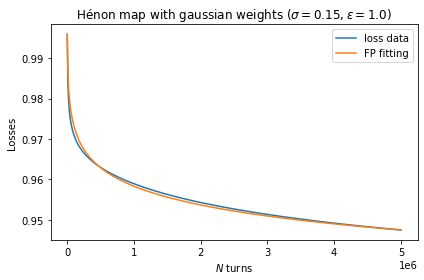

In [345]:
index = 0
plt.figure()
plt.plot(turn_sampling[::-1], gaussian_losses[index][::-1], label="loss data")
plt.plot(turn_sampling[::-1], finals_standard[index], label="FP fitting")

plt.legend()
plt.xlabel("$N$ turns")
plt.ylabel("Losses")
plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4})$".format(sigma, epsilons[index]))

plt.tight_layout()

In [69]:
eps_fp = []
k_fp = []
k_err_fp = []
I_star_fp = []
I_star_err_fp = []

chi_fp = []
rchi_fp = []

chi_fp_reconstructed = []

for i, result in enumerate(results_standard):
    k_fp.append(result.params.get("k").value)
    k_err_fp.append(result.params.get("k").stderr)
    I_star_fp.append(result.params.get("I_star").value)
    I_star_err_fp.append(result.params.get("I_star").stderr)
    eps_fp.append(epsilons[i])
    chi_fp.append(result.chisqr)
    rchi_fp.append(result.redchi)
    chi_fp_reconstructed.append(chi2(finals_standard[i], gaussian_losses[i][::-1]))

In [70]:
eps_fp_no_beg = []
k_fp_no_beg = []
k_err_fp_no_beg = []
I_star_fp_no_beg = []
I_star_err_fp_no_beg = []

chi_fp_no_beg = []
rchi_fp_no_beg = []

for i, result in enumerate(results_no_beg):
    k_fp_no_beg.append(result.params.get("k").value)
    k_err_fp_no_beg.append(result.params.get("k").stderr)
    I_star_fp_no_beg.append(result.params.get("I_star").value)
    I_star_err_fp_no_beg.append(result.params.get("I_star").stderr)
    eps_fp_no_beg.append(epsilons[i])
    chi_fp_no_beg.append(result.chisqr)
    rchi_fp_no_beg.append(result.redchi)

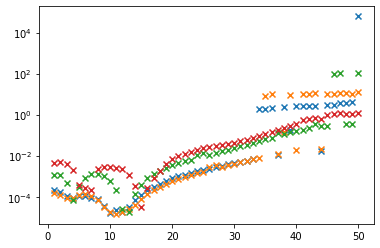

In [99]:
plt.figure()

plt.scatter(eps_fp, chi_fp_reconstructed, marker="x")
plt.scatter(eps_fp, chi_fp_no_end_reconstructed, marker="x")
plt.scatter(eps_fp, chi_fp_no_end_medium_reconstructed, marker="x")
plt.scatter(eps_fp, chi_fp_no_end_extreme_reconstructed, marker="x")

plt.yscale("log")

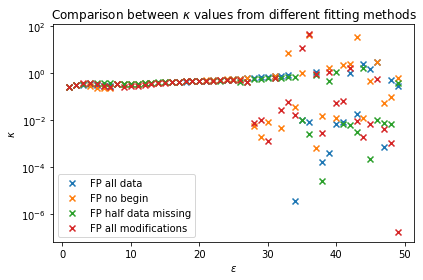

In [100]:
plt.figure()

plt.scatter(eps_fp[:-1], k_fp[:-1], marker="x", label="FP all data")
plt.scatter(eps_fp[:-1], k_fp_no_beg[:-1], marker="x", label="FP no begin")
plt.scatter(eps_fp[:-1], k_fp_no_end[:-1], marker="x", label="FP half data missing")
plt.scatter(eps_fp[:-1], k_fp_all_mods[:-1], marker="x", label="FP all modifications")

plt.legend()
plt.xlabel("$\\varepsilon$")
plt.ylabel("$\\kappa$")
plt.title("Comparison between $\\kappa$ values from different fitting methods")
plt.tight_layout()

plt.yscale("log")

plt.savefig("../img/fp_variants_henon_k_all.png", dpi=600)

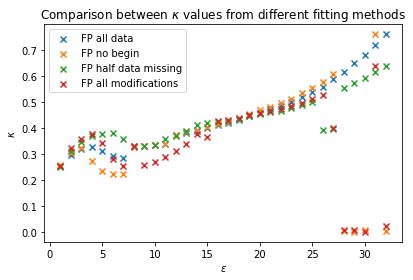

In [101]:
plt.figure()

lim = 32

plt.scatter(eps_fp[:lim], k_fp[:lim], marker="x", label="FP all data")
plt.scatter(eps_fp[:lim], k_fp_no_beg[:lim], marker="x", label="FP no begin")
plt.scatter(eps_fp[:lim], k_fp_no_end[:lim], marker="x", label="FP half data missing")
plt.scatter(eps_fp[:lim], k_fp_all_mods[:lim], marker="x", label="FP all modifications")

plt.legend()
plt.xlabel("$\\varepsilon$")
plt.ylabel("$\\kappa$")
plt.title("Comparison between $\\kappa$ values from different fitting methods")
plt.tight_layout()

#plt.yscale("log")

plt.savefig("../img/fp_variants_henon_k.png", dpi=600)

In [72]:
k_fp = np.asarray(k_fp)
k_fp_no_end = np.asarray(k_fp_no_end)
k_fp_no_end_medium = np.asarray(k_fp_no_end_medium)
k_fp_no_end_extreme = np.asarray(k_fp_no_end_extreme)

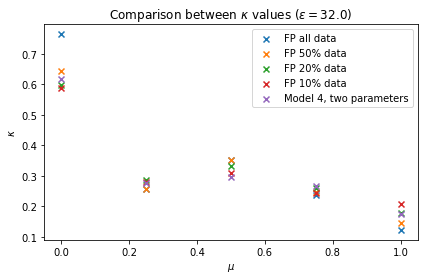

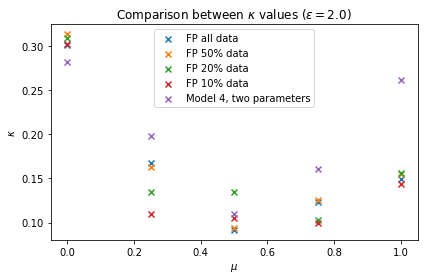

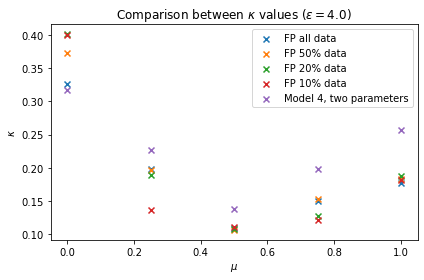

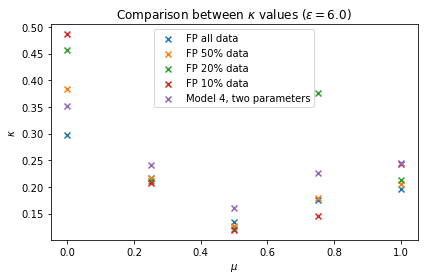

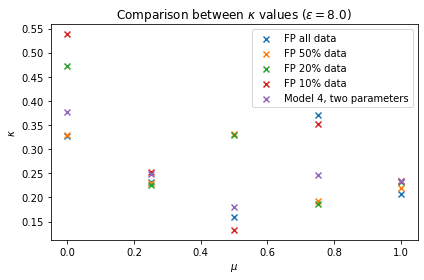

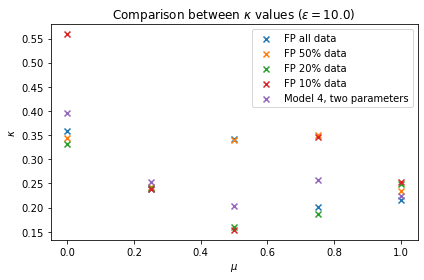

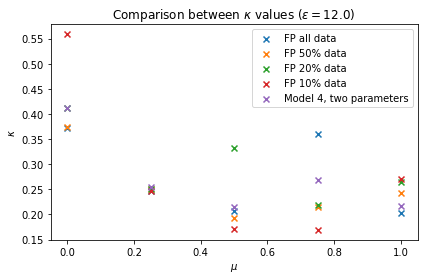

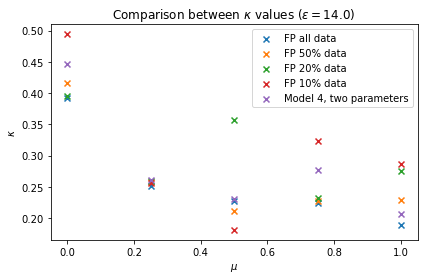

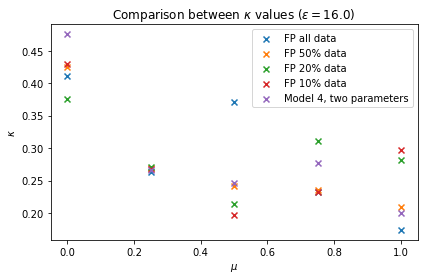

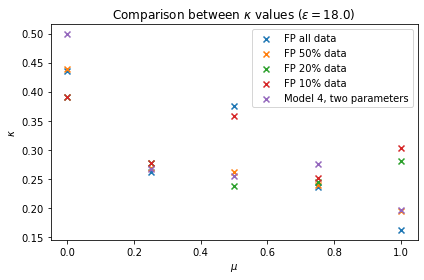

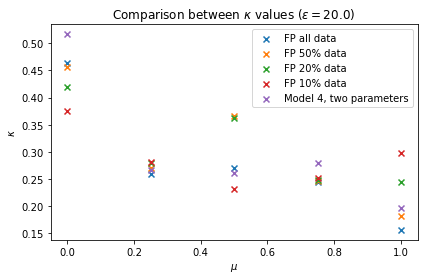

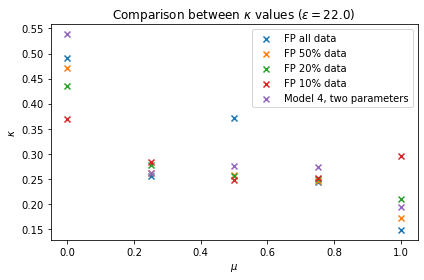

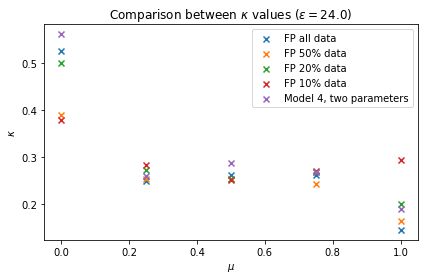

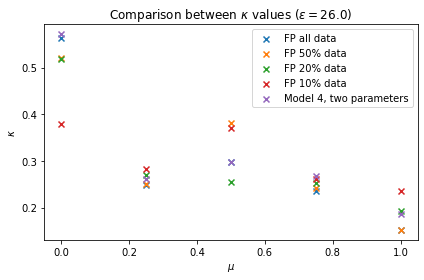

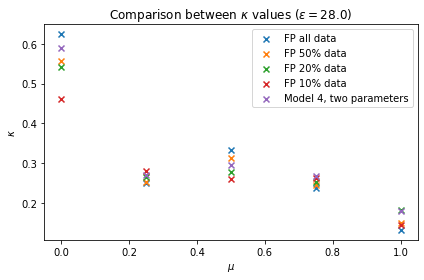

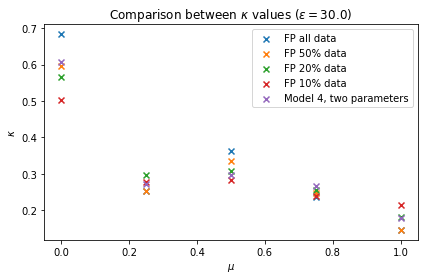

In [84]:
for i, epsilon in enumerate(epsilon_set):

    plt.figure()

    plt.scatter(mus[epsilons == epsilon], k_fp[epsilons == epsilon], marker="x", label="FP all data")
    plt.scatter(mus[epsilons == epsilon], k_fp_no_end[epsilons == epsilon], marker="x", label="FP 50% data")
    plt.scatter(mus[epsilons == epsilon], k_fp_no_end_medium[epsilons == epsilon], marker="x", label="FP 20% data")
    plt.scatter(mus[epsilons == epsilon], k_fp_no_end_extreme[epsilons == epsilon], marker="x", label="FP 10% data")
    plt.scatter(mus[epsilons == epsilon], k2[epsilons == epsilon], marker="x", label="Model 4, two parameters")

    plt.legend()
    plt.xlabel("$\\mu$")
    plt.ylabel("$\\kappa$")
    plt.title("Comparison between $\\kappa$ values $(\\varepsilon={})$".format(epsilon))
    plt.tight_layout()

    #plt.yscale("log")

    plt.savefig("../img/octo_fp_variants_henon_k_with_model4_eps_{}.png".format(epsilon), dpi=600)

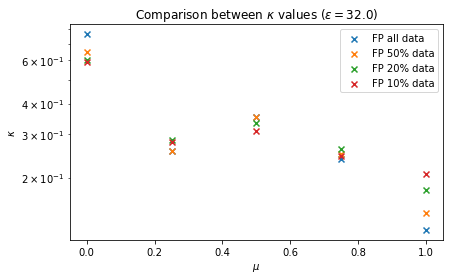

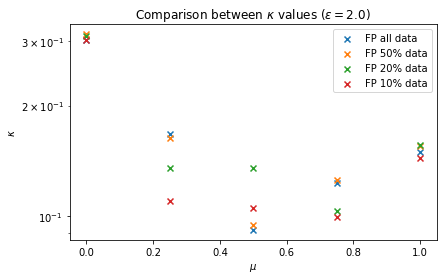

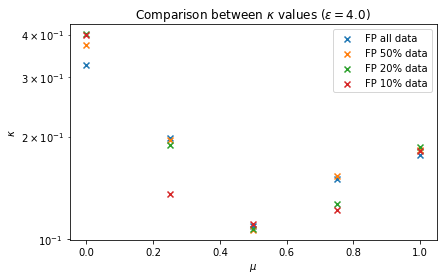

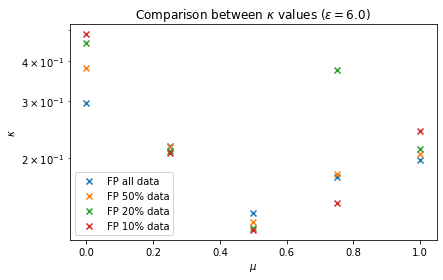

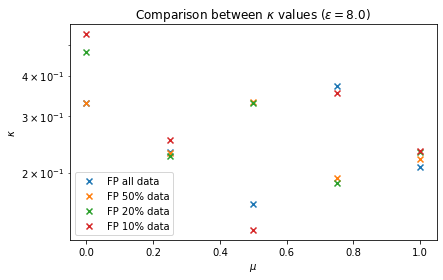

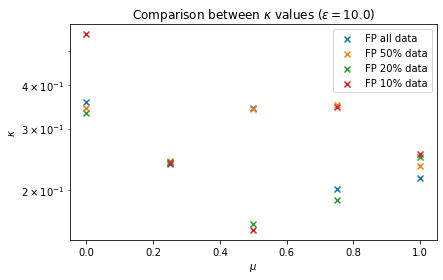

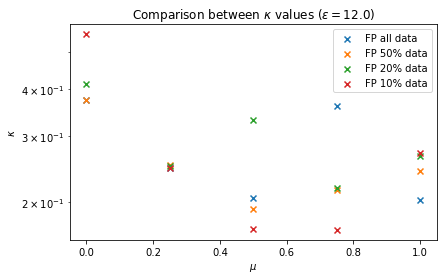

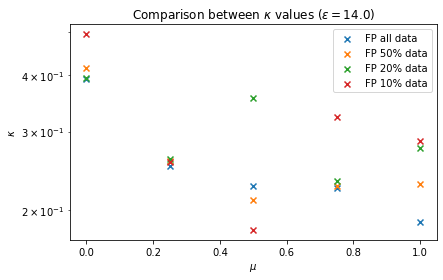

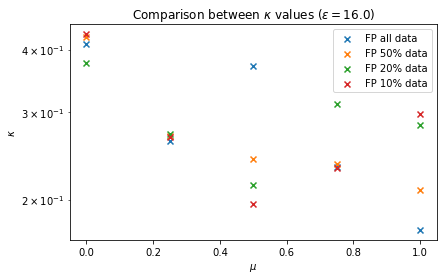

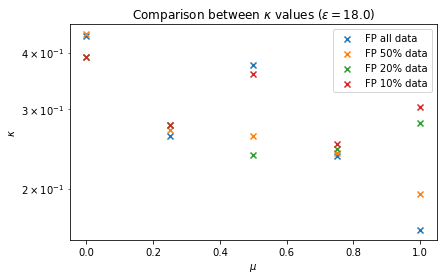

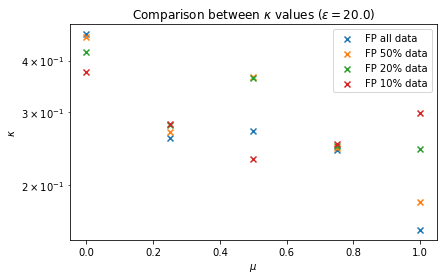

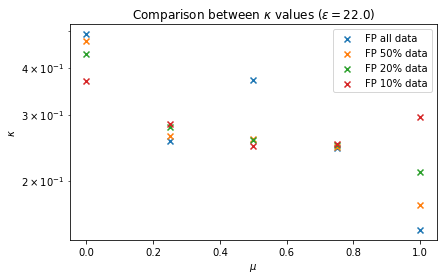

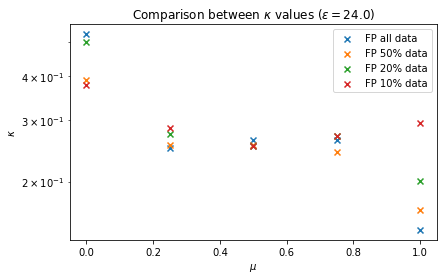

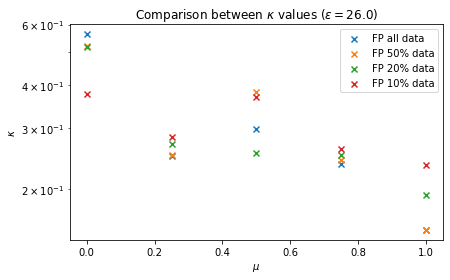

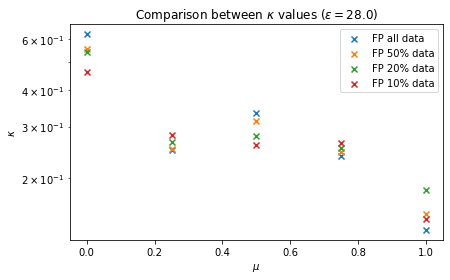

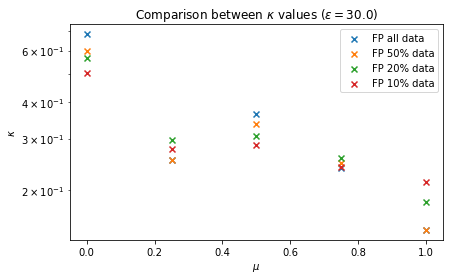

In [81]:
for i, epsilon in enumerate(epsilon_set):

    plt.figure()

    plt.scatter(mus[epsilons == epsilon], k_fp[epsilons == epsilon], marker="x", label="FP all data")
    plt.scatter(mus[epsilons == epsilon], k_fp_no_end[epsilons == epsilon], marker="x", label="FP 50% data")
    plt.scatter(mus[epsilons == epsilon], k_fp_no_end_medium[epsilons == epsilon], marker="x", label="FP 20% data")
    plt.scatter(mus[epsilons == epsilon], k_fp_no_end_extreme[epsilons == epsilon], marker="x", label="FP 10% data")

    plt.legend()
    plt.xlabel("$\\mu$")
    plt.ylabel("$\\kappa$")
    plt.title("Comparison between $\\kappa$ values $(\\varepsilon={})$".format(epsilon))
    plt.tight_layout()

    plt.yscale("log")

    plt.savefig("../img/octo_fp_variants_henon_k_log_eps_{}.png".format(epsilon), dpi=600)

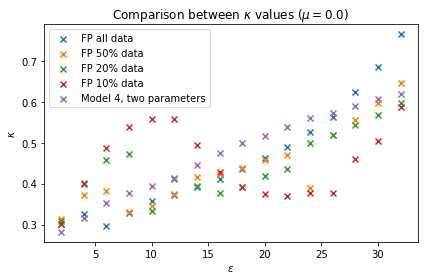

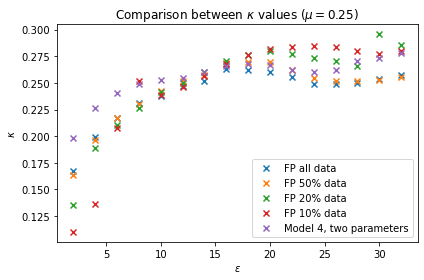

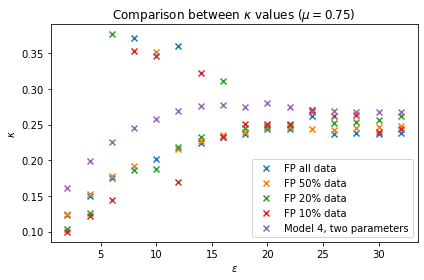

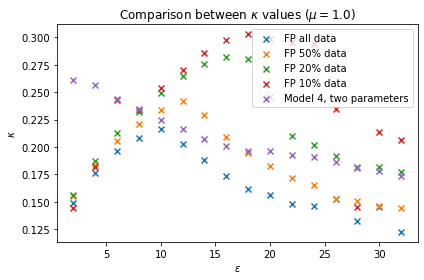

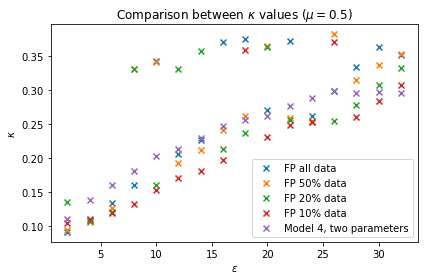

In [83]:
for i, mu in enumerate(mu_set):

    plt.figure()

    plt.scatter(epsilons[mus == mu], k_fp[mus == mu], marker="x", label="FP all data")
    plt.scatter(epsilons[mus == mu], k_fp_no_end[mus == mu], marker="x", label="FP 50% data")
    plt.scatter(epsilons[mus == mu], k_fp_no_end_medium[mus == mu], marker="x", label="FP 20% data")
    plt.scatter(epsilons[mus == mu], k_fp_no_end_extreme[mus == mu], marker="x", label="FP 10% data")
    plt.scatter(epsilons[mus == mu], k2[mus == mu], marker="x", label="Model 4, two parameters")

    plt.legend()
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\kappa$")
    plt.title("Comparison between $\\kappa$ values $(\\mu={})$".format(mu))
    plt.tight_layout()

    #plt.yscale("log")

    plt.savefig("../img/octo_fp_variants_henon_k_with_model4_mu_{}.png".format(mu), dpi=600)

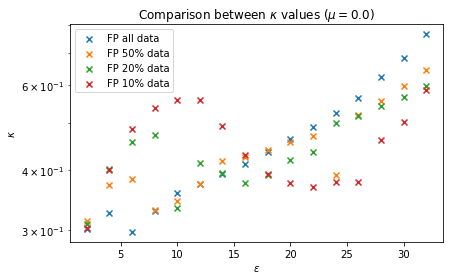

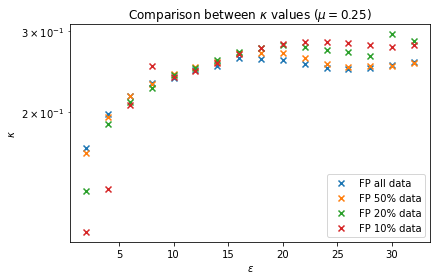

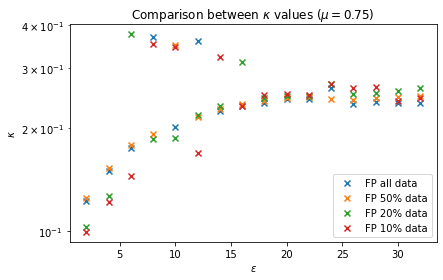

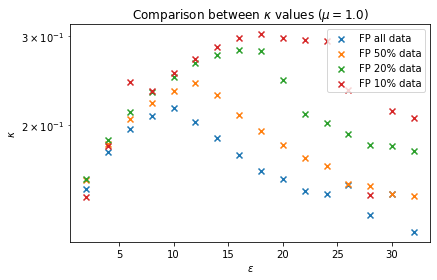

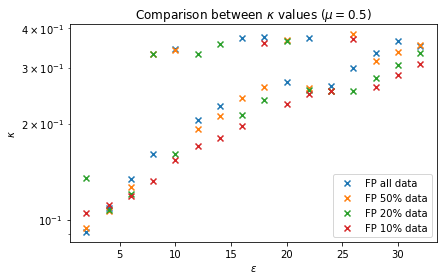

In [80]:
for i, mu in enumerate(mu_set):

    plt.figure()

    plt.scatter(epsilons[mus == mu], k_fp[mus == mu], marker="x", label="FP all data")
    plt.scatter(epsilons[mus == mu], k_fp_no_end[mus == mu], marker="x", label="FP 50% data")
    plt.scatter(epsilons[mus == mu], k_fp_no_end_medium[mus == mu], marker="x", label="FP 20% data")
    plt.scatter(epsilons[mus == mu], k_fp_no_end_extreme[mus == mu], marker="x", label="FP 10% data")

    plt.legend()
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\kappa$")
    plt.title("Comparison between $\\kappa$ values $(\\mu={})$".format(mu))
    plt.tight_layout()

    plt.yscale("log")

    plt.savefig("../img/octo_fp_variants_henon_k_log_mu_{}.png".format(mu), dpi=600)

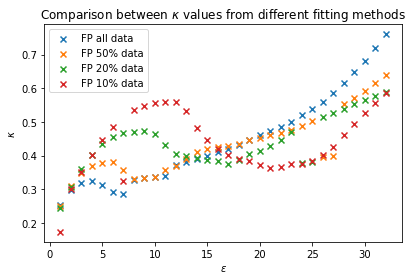

In [106]:
plt.figure()

lim = 32

plt.scatter(eps_fp[:lim], k_fp[:lim], marker="x", label="FP all data")
plt.scatter(eps_fp[:lim], k_fp_no_end[:lim], marker="x", label="FP 50% data")
plt.scatter(eps_fp[:lim], k_fp_no_end_medium[:lim], marker="x", label="FP 20% data")
plt.scatter(eps_fp[:lim], k_fp_no_end_extreme[:lim], marker="x", label="FP 10% data")

plt.legend()
plt.xlabel("$\\varepsilon$")
plt.ylabel("$\\kappa$")
plt.title("Comparison between $\\kappa$ values from different fitting methods")
plt.tight_layout()

#plt.yscale("log")

plt.savefig("../img/fp_variants_henon_k.png", dpi=600)

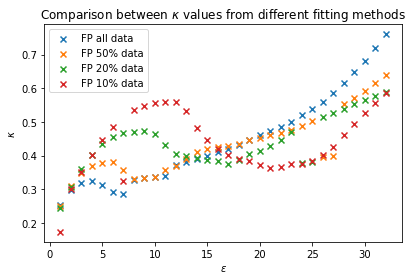

In [107]:
plt.figure()

lim = 32

plt.scatter(eps_fp[:lim], k_fp[:lim], marker="x", label="FP all data")
plt.scatter(eps_fp[:lim], k_fp_no_end[:lim], marker="x", label="FP 50% data")
plt.scatter(eps_fp[:lim], k_fp_no_end_medium[:lim], marker="x", label="FP 20% data")
plt.scatter(eps_fp[:lim], k_fp_no_end_extreme[:lim], marker="x", label="FP 10% data")

plt.legend()
plt.xlabel("$\\varepsilon$")
plt.ylabel("$\\kappa$")
plt.title("Comparison between $\\kappa$ values from different fitting methods")
plt.tight_layout()

#plt.yscale("log")

plt.savefig("../img/fp_variants_henon_k.png", dpi=600)

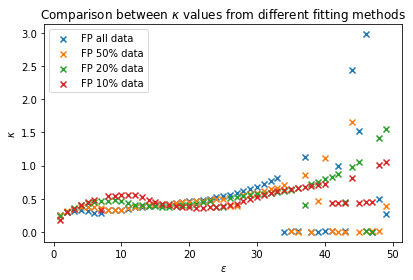

In [108]:
plt.figure()

lim = -1

plt.scatter(eps_fp[:lim], k_fp[:lim], marker="x", label="FP all data")
plt.scatter(eps_fp[:lim], k_fp_no_end[:lim], marker="x", label="FP 50% data")
plt.scatter(eps_fp[:lim], k_fp_no_end_medium[:lim], marker="x", label="FP 20% data")
plt.scatter(eps_fp[:lim], k_fp_no_end_extreme[:lim], marker="x", label="FP 10% data")

plt.legend()
plt.xlabel("$\\varepsilon$")
plt.ylabel("$\\kappa$")
plt.title("Comparison between $\\kappa$ values from different fitting methods")
plt.tight_layout()

#plt.yscale("log")

plt.savefig("../img/fp_variants_henon_k_all.png", dpi=600)

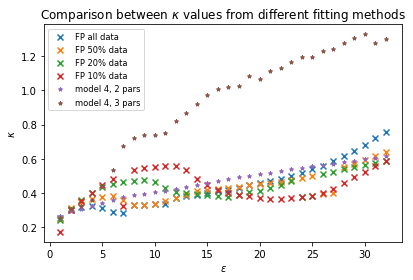

In [110]:
plt.figure()

lim = 32

plt.scatter(eps_fp[:lim], k_fp[:lim], marker="x", label="FP all data")
plt.scatter(eps_fp[:lim], k_fp_no_end[:lim], marker="x", label="FP 50% data")
plt.scatter(eps_fp[:lim], k_fp_no_end_medium[:lim], marker="x", label="FP 20% data")
plt.scatter(eps_fp[:lim], k_fp_no_end_extreme[:lim], marker="x", label="FP 10% data")
plt.scatter(eps_fp[:lim], k2[:lim], s=15, marker="*", label="model 4, 2 pars")
plt.scatter(eps_fp[:lim], k3[:lim], s=15, marker="*", label="model 4, 3 pars")

plt.legend(fontsize="small")
plt.xlabel("$\\varepsilon$")
plt.ylabel("$\\kappa$")
plt.title("Comparison between $\\kappa$ values from different fitting methods")
plt.tight_layout()

#plt.yscale("log")

plt.savefig("../img/fp_variants_henon_k_all_and_models.png", dpi=600)

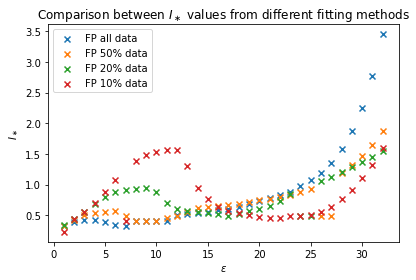

In [111]:
plt.figure()

lim = 32

plt.scatter(eps_fp[:lim], I_star_fp[:lim], marker="x", label="FP all data")
plt.scatter(eps_fp[:lim], I_star_fp_no_end[:lim], marker="x", label="FP 50% data")
plt.scatter(eps_fp[:lim], I_star_fp_no_end_medium[:lim], marker="x", label="FP 20% data")
plt.scatter(eps_fp[:lim], I_star_fp_no_end_extreme[:lim], marker="x", label="FP 10% data")

plt.legend()
plt.xlabel("$\\varepsilon$")
plt.ylabel("$I_\\ast$")
plt.title("Comparison between $I_\\ast$ values from different fitting methods")
plt.tight_layout()

#plt.yscale("log")

plt.savefig("../img/fp_variants_henon_I_star.png", dpi=600)

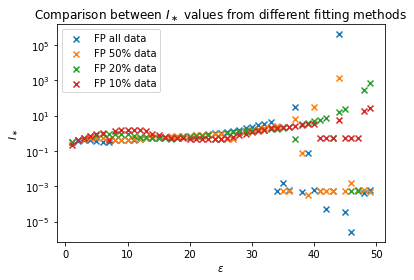

In [113]:
plt.figure()

lim = -1

plt.scatter(eps_fp[:lim], I_star_fp[:lim], marker="x", label="FP all data")
plt.scatter(eps_fp[:lim], I_star_fp_no_end[:lim], marker="x", label="FP 50% data")
plt.scatter(eps_fp[:lim], I_star_fp_no_end_medium[:lim], marker="x", label="FP 20% data")
plt.scatter(eps_fp[:lim], I_star_fp_no_end_extreme[:lim], marker="x", label="FP 10% data")

plt.legend()
plt.xlabel("$\\varepsilon$")
plt.ylabel("$I_\\ast$")
plt.title("Comparison between $I_\\ast$ values from different fitting methods")
plt.tight_layout()

plt.yscale("log")

plt.savefig("../img/fp_variants_henon_I_star_all.png", dpi=600)

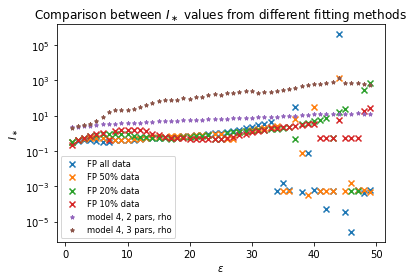

In [114]:
plt.figure()

lim = -1

plt.scatter(eps_fp[:lim], I_star_fp[:lim], marker="x", label="FP all data")
plt.scatter(eps_fp[:lim], I_star_fp_no_end[:lim], marker="x", label="FP 50% data")
plt.scatter(eps_fp[:lim], I_star_fp_no_end_medium[:lim], marker="x", label="FP 20% data")
plt.scatter(eps_fp[:lim], I_star_fp_no_end_extreme[:lim], marker="x", label="FP 10% data")
plt.scatter(eps_fp[:lim], rho2[:lim], s=15, marker="*", label="model 4, 2 pars, rho")
plt.scatter(eps_fp[:lim], rho3[:lim], s=15, marker="*", label="model 4, 3 pars, rho")

plt.legend(fontsize="small")
plt.xlabel("$\\varepsilon$")
plt.ylabel("$I_\\ast$")
plt.title("Comparison between $I_\\ast$ values from different fitting methods")
plt.tight_layout()

plt.yscale("log")

plt.savefig("../img/fp_variants_henon_I_star_all_and_models.png", dpi=600)

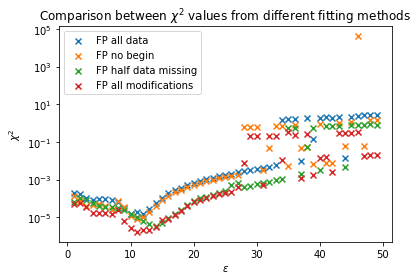

In [115]:
plt.figure()

lim = -1

plt.scatter(eps_fp[:lim], chi_fp[:lim], marker="x", label="FP all data")
plt.scatter(eps_fp[:lim], chi_fp_no_beg[:lim], marker="x", label="FP no begin")
plt.scatter(eps_fp[:lim], chi_fp_no_end[:lim], marker="x", label="FP half data missing")
plt.scatter(eps_fp[:lim], chi_fp_all_mods[:lim], marker="x", label="FP all modifications")

plt.legend()
plt.xlabel("$\\varepsilon$")
plt.ylabel("$\\chi^2$")
plt.title("Comparison between $\\chi^2$ values from different fitting methods")
plt.tight_layout()
plt.yscale("log")

#plt.yscale("log")

In [ ]:
plt.figure()

plt.errorbar(eps_fp[:-1], k_fp[:-1], yerr=k_err_fp[:-1], linewidth=0, elinewidth=2, marker="x", label="FP all data")
plt.errorbar(eps_fp[:-1], k_fp_no_beg[:-1], yerr=k_err_fp_no_beg[:-1], linewidth=0, elinewidth=2, marker="x", label="FP no begin")
plt.errorbar(eps_fp[:-1], k_fp_no_end[:-1], yerr=k_err_fp_no_end[:-1], linewidth=0, elinewidth=2, marker="x", label="FP half data missing")
plt.errorbar(eps_fp[:-1], k_fp_all_mods[:-1], yerr=k_err_fp_all_mods[:-1], linewidth=0, elinewidth=2, marker="x", label="FP all modifications")

plt.legend()
plt.xlabel("$\\varepsilon$")
plt.ylabel("$\\kappa$")
plt.title("Comparison between $\\kappa$ values from different fitting methods")
plt.tight_layout()

plt.savefig("../img/fp_variants_henon_k.png", dpi=600)

In [ ]:
plt.figure()

plt.scatter(eps_fp[:-1], I_star_fp[:-1], marker="x", label="FP all data")
plt.scatter(eps_fp[:-1], I_star_fp_no_beg[:-1], marker="x", label="FP no begin")
plt.scatter(eps_fp[:-1], I_star_fp_no_end[:-1], marker="x", label="FP half data missing")
plt.scatter(eps_fp[:-1], I_star_fp_all_mods[:-1], marker="x", label="FP all modifications")

plt.legend()
plt.xlabel("$\\varepsilon$")
plt.ylabel("$I_\\ast$")
plt.title("Comparison between $I_\\ast$ values from different fitting methods")
plt.tight_layout()

plt.yscale("log")

plt.savefig("../img/fp_variants_henon_Istar_all.png", dpi=600)

In [ ]:
plt.figure()

lim = 36

plt.scatter(eps_fp[:lim], I_star_fp[:lim], marker="x", label="FP all data")
plt.scatter(eps_fp[:lim], I_star_fp_no_beg[:lim], marker="x", label="FP no begin")
plt.scatter(eps_fp[:lim], I_star_fp_no_end[:lim], marker="x", label="FP half data missing")
plt.scatter(eps_fp[:lim], I_star_fp_all_mods[:lim], marker="x", label="FP all modifications")

plt.legend()
plt.xlabel("$\\varepsilon$")
plt.ylabel("$I_\\ast$")
plt.title("Comparison between $I_\\ast$ values from different fitting methods")
plt.tight_layout()

#plt.yscale("log")

plt.savefig("../img/fp_variants_henon_Istar_all.png", dpi=600)

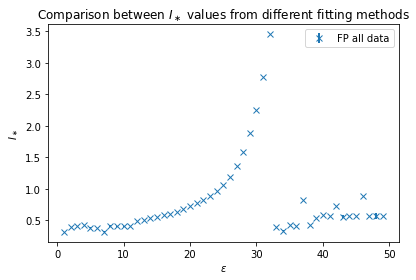

In [97]:
plt.figure()

plt.errorbar(eps_fp[:-1], I_star_fp[:-1], yerr=I_star_err_fp[:-1], linewidth=0, elinewidth=2, marker="x", label="FP all data")
plt.errorbar(eps_fp[:-1], I_star_fp_no_beg[:-1], yerr=I_star_err_fp_no_beg[:-1], linewidth=0, elinewidth=2, marker="x", label="FP no begin")
plt.errorbar(eps_fp[:-1], I_star_fp_no_end[:-1], yerr=I_star_err_fp_no_end[:-1], linewidth=0, elinewidth=2, marker="x", label="FP half data missing")
plt.errorbar(eps_fp[:-1], I_star_fp_all_mods[:-1], yerr=I_star_err_fp_all_mods[:-1], linewidth=0, elinewidth=2, marker="x", label="FP all modifications")

plt.legend()
plt.xlabel("$\\varepsilon$")
plt.ylabel("$I_\\ast$")
plt.title("Comparison between $I_\\ast$ values from different fitting methods")
plt.tight_layout()

plt.savefig("../img/fp_variants_henon_Istar.png", dpi=600)

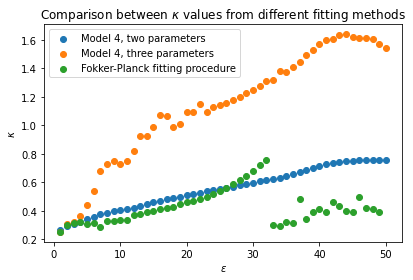

In [98]:
plt.figure()

plt.scatter(epsilons, k2, label="Model 4, two parameters")
plt.scatter(epsilons, k3, label="Model 4, three parameters")
plt.scatter(eps_fp[:-1], k_fp[:-1], label="Fokker-Planck fitting procedure")

plt.legend()
plt.xlabel("$\\varepsilon$")
plt.ylabel("$\\kappa$")
plt.title("Comparison between $\\kappa$ values from different fitting methods")
plt.tight_layout()

plt.savefig("../img/general_henon_clean.png", dpi=600)

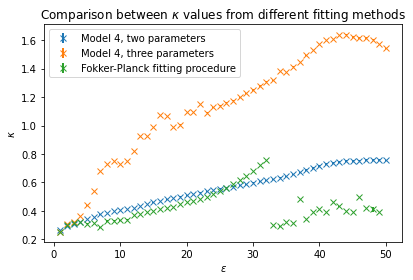

In [129]:
plt.figure()

plt.errorbar(epsilons, k2, yerr=k2_err, linewidth=0, elinewidth=2, marker="x", label="Model 4, two parameters")
plt.errorbar(epsilons, k3, yerr=k3_err, linewidth=0, elinewidth=2, marker="x", label="Model 4, three parameters")
plt.errorbar(eps_fp[:-1], k_fp[:-1], yerr=k_err_fp[:-1], linewidth=0, elinewidth=2, marker="x", label="Fokker-Planck fitting procedure")

plt.legend()
plt.xlabel("$\\varepsilon$")
plt.ylabel("$\\kappa$")
plt.title("Comparison between $\\kappa$ values from different fitting methods")
plt.tight_layout()

plt.savefig("../img/general_henon_clean_err.png", dpi=600)

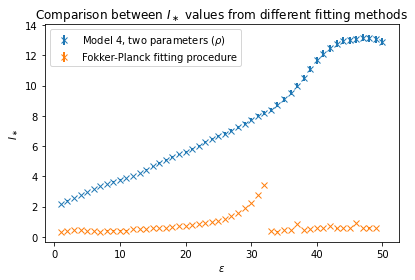

In [132]:
plt.figure()

plt.errorbar(epsilons, rho2, yerr=rho2_err, linewidth=0, elinewidth=2, marker="x", label="Model 4, two parameters $(\\rho)$")
#plt.errorbar(epsilons, rho3, yerr=rho3_err, linewidth=0, elinewidth=2, marker="x", label="Model 4, three parameters")
plt.errorbar(eps_fp[:-1], np.asarray(I_star_fp[:-1]), yerr=I_star_err_fp[:-1], linewidth=0, elinewidth=2, marker="x", label="Fokker-Planck fitting procedure")

#plt.yscale("log")

plt.legend()
plt.xlabel("$\\varepsilon$")
plt.ylabel("$I_\\ast$")
plt.title("Comparison between $I_\\ast$ values from different fitting methods")
plt.tight_layout()

plt.savefig("../img/general_henon_clean_I_star_err.png", dpi=600)

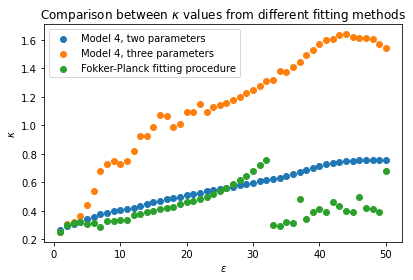

In [131]:
plt.figure()

plt.scatter(epsilons, k2, label="Model 4, two parameters")
plt.scatter(epsilons, k3, label="Model 4, three parameters")
plt.scatter(eps_fp[:], k_fp[:], label="Fokker-Planck fitting procedure")

plt.legend()
plt.xlabel("$\\varepsilon$")
plt.ylabel("$\\kappa$")
plt.title("Comparison between $\\kappa$ values from different fitting methods")
plt.tight_layout()

plt.savefig("../img/general_henon.png", dpi=600)

## REDO Fokker-Planck but starting from another k

### All

In [138]:
temp_result = []
temp_final = []
temp_eps = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit,
        args=(
            autofit_fp,
            turn_sampling[::-1],
            gaussian_losses[i][::-1],
            I0,
            I_max,
            k2[i],
            epsilons[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_result, temp_final), key=lambda x: x[0])

bis_results_standard = [T[1] for T in TMP]
bis_finals_standard = [T[2] for T in TMP]

In [139]:
with open("../data/octo_bis_fp_henon_fit.pkl", 'wb') as f:
    pickle.dump((bis_results_standard, bis_finals_standard), f)

In [140]:
with open("../data/octo_bis_fp_henon_fit.pkl", 'rb') as f:
    bis_results_standard, bis_finals_standard = pickle.load(f)

### No begin

In [141]:
temp_result = []
temp_final = []
temp_eps = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit,
        args=(
            autofit_fp,
            (turn_sampling[turn_sampling > 10000])[::-1],
            (gaussian_losses[i][turn_sampling > 10000])[::-1],
            I0,
            I_max,
            k2[i],
            epsilons[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_result, temp_final), key=lambda x: x[0])

bis_results_no_beg = [T[1] for T in TMP]
bis_finals_no_beg = [T[2] for T in TMP]

In [142]:
with open("../data/octo_bis_fp_henon_fit_no_beg.pkl", 'wb') as f:
    pickle.dump((bis_results_no_beg, bis_finals_no_beg), f)

In [143]:
with open("../data/octo_bis_fp_henon_fit_no_beg.pkl", 'rb') as f:
    bis_results_no_beg, bis_finals_no_beg = pickle.load(f)

### No end

In [144]:
temp_result = []
temp_final = []
temp_eps = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit,
        args=(
            autofit_fp,
            (turn_sampling[len(turn_sampling)//2:])[::-1],
            (gaussian_losses[i][len(turn_sampling)//2:])[::-1],
            I0,
            I_max,
            k2[i],
            epsilons[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_result, temp_final), key=lambda x: x[0])

bis_results_no_end = [T[1] for T in TMP]
bis_finals_no_end = [T[2] for T in TMP]

In [145]:
with open("../data/octo_bis_fp_henon_fit_no_end.pkl", 'wb') as f:
    pickle.dump((bis_results_no_end, bis_finals_no_end), f)

In [146]:
with open("../data/octo_bis_fp_henon_fit_no_end.pkl", 'rb') as f:
    bis_results_no_end, bis_finals_no_end = pickle.load(f)

### No beg no end

In [147]:
temp_result = []
temp_final = []
temp_eps = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit,
        args=(
            autofit_fp,
            ((turn_sampling[turn_sampling > 10000])[len(turn_sampling)//2:])[::-1],
            ((gaussian_losses[i][turn_sampling > 10000])[len(turn_sampling)//2:])[::-1],
            I0,
            I_max,
            k2[i],
            epsilons[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_result, temp_final), key=lambda x: x[0])

bis_results_all_mods = [T[1] for T in TMP]
bis_finals_all_mods = [T[2] for T in TMP]

In [148]:
with open("../data/octo_bis_fp_henon_fit_all_mods.pkl", 'wb') as f:
    pickle.dump((bis_results_all_mods, bis_finals_all_mods), f)

In [149]:
with open("../data/octo_bis_fp_henon_fit_all_mods.pkl", 'rb') as f:
    bis_results_all_mods, bis_finals_all_mods = pickle.load(f)

In [150]:
bis_eps_fp = []
bis_k_fp = []
bis_k_err_fp = []
bis_I_star_fp = []
bis_I_star_err_fp = []

for i, result in enumerate(bis_results_standard):
    bis_k_fp.append(result.params.get("k").value)
    bis_k_err_fp.append(result.params.get("k").stderr)
    bis_I_star_fp.append(result.params.get("I_star").value)
    bis_I_star_err_fp.append(result.params.get("I_star").stderr)
    bis_eps_fp.append(epsilons[i])

In [151]:
bis_eps_fp_no_beg = []
bis_k_fp_no_beg = []
bis_k_err_fp_no_beg = []
bis_I_star_fp_no_beg = []
bis_I_star_err_fp_no_beg = []

for i, result in enumerate(bis_results_no_beg):
    bis_k_fp_no_beg.append(result.params.get("k").value)
    bis_k_err_fp_no_beg.append(result.params.get("k").stderr)
    bis_I_star_fp_no_beg.append(result.params.get("I_star").value)
    bis_I_star_err_fp_no_beg.append(result.params.get("I_star").stderr)
    bis_eps_fp_no_beg.append(epsilons[i])

In [152]:
eps_fp_no_end = []
k_fp_no_end = []
k_err_fp_no_end = []
I_star_fp_no_end = []
I_star_err_fp_no_end = []

for i, result in enumerate(bis_results_no_end):
    k_fp_no_end.append(result.params.get("k").value)
    k_err_fp_no_end.append(result.params.get("k").stderr)
    I_star_fp_no_end.append(result.params.get("I_star").value)
    I_star_err_fp_no_end.append(result.params.get("I_star").stderr)
    eps_fp_no_end.append(epsilons[i])

In [153]:
bis_eps_fp_all_mods = []
bis_k_fp_all_mods = []
bis_k_err_fp_all_mods = []
bis_I_star_fp_all_mods = []
bis_I_star_err_fp_all_mods = []

for i, result in enumerate(bis_results_all_mods):
    bis_k_fp_all_mods.append(result.params.get("k").value)
    bis_k_err_fp_all_mods.append(result.params.get("k").stderr)
    bis_I_star_fp_all_mods.append(result.params.get("I_star").value)
    bis_I_star_err_fp_all_mods.append(result.params.get("I_star").stderr)
    bis_eps_fp_all_mods.append(epsilons[i])

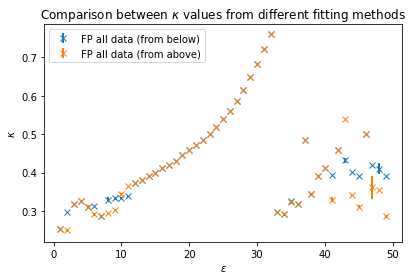

In [154]:
plt.figure()

plt.errorbar(eps_fp[:-1], k_fp[:-1], yerr=k_err_fp[:-1], linewidth=0, elinewidth=2, marker="x", label="FP all data (from below)")
plt.errorbar(eps_fp[:-1], bis_k_fp[:-1], yerr=bis_k_err_fp[:-1], linewidth=0, elinewidth=2, marker="x", label="FP all data (from above)")

plt.legend()
plt.xlabel("$\\varepsilon$")
plt.ylabel("$\\kappa$")
plt.title("Comparison between $\\kappa$ values from different fitting methods")
plt.tight_layout()

plt.savefig("../img/fp_variants_henon_above_below.png", dpi=600)

## Other Plots...

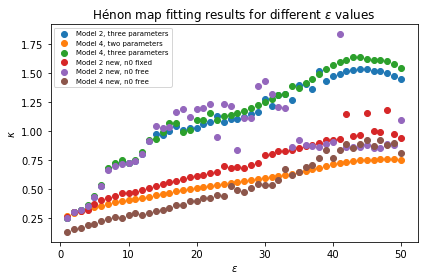

In [134]:
plt.figure()
plt.scatter(epsilons, k1, label="Model 2, three parameters")
plt.scatter(epsilons, k2, label="Model 4, two parameters")
plt.scatter(epsilons, k3, label="Model 4, three parameters")
plt.scatter(epsilons, k4, label="Model 2 new, n0 fixed")
#plt.scatter(epsilons, k5, label="Model 4 new, n0 fixed")
plt.scatter(epsilons, k6, label="Model 2 new, n0 free")
plt.scatter(epsilons, k7, label="Model 4 new, n0 free")

plt.legend(fontsize="x-small")
plt.xlabel("$\\varepsilon$")
plt.ylabel("$\\kappa$")
plt.title("Hénon map fitting results for different $\\epsilon$ values")
plt.tight_layout()

plt.savefig("../img/all_fits_henon.png", dpi=600)

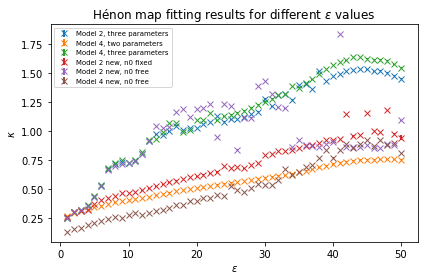

In [135]:
plt.figure()
plt.errorbar(epsilons, k1, yerr=k1_err, linewidth=0, elinewidth=2, marker="x", label="Model 2, three parameters")
plt.errorbar(epsilons, k2, yerr=k2_err, linewidth=0, elinewidth=2, marker="x", label="Model 4, two parameters")
plt.errorbar(epsilons, k3, yerr=k3_err, linewidth=0, elinewidth=2, marker="x", label="Model 4, three parameters")
plt.errorbar(epsilons, k4, yerr=k4_err, linewidth=0, elinewidth=2, marker="x", label="Model 2 new, n0 fixed")
#plt.errorbar(epsilons, k5, yerr=k5_err, linewidth=0, elinewidth=2, marker="x", label="Model 4 new, n0 fixed")
plt.errorbar(epsilons, k6, yerr=k6_err, linewidth=0, elinewidth=2, marker="x", label="Model 2 new, n0 free")
plt.errorbar(epsilons, k7, yerr=k7_err, linewidth=0, elinewidth=2, marker="x", label="Model 4 new, n0 free")

plt.legend(fontsize="x-small")
plt.xlabel("$\\varepsilon$")
plt.ylabel("$\\kappa$")
plt.title("Hénon map fitting results for different $\\epsilon$ values")
plt.tight_layout()

plt.savefig("../img/all_fits_henon_err.png", dpi=600)

In [136]:
with open("../data/all_henon_fit.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_2,
        real_finals_model_2,
        real_results_model_4,
        real_finals_model_4,
        real_results_model_4_free,
        real_finals_model_4_free,
        real_results_model_2_bis,
        real_finals_model_2_bis,
        real_results_model_4_bis,
        real_finals_model_4_bis,
        real_results_model_2_bis_free,
        real_finals_model_2_bis_free,
        real_results_model_4_bis_free,
        real_finals_model_4_bis_free
    ), f)

In [137]:
with open("../data/octo_all_henon_fit.pkl", 'rb') as f:
    real_results_model_2, real_finals_model_2, real_results_model_4, real_finals_model_4, real_results_model_4_free, real_finals_model_4_free, real_results_model_2_bis, real_finals_model_2_bis, real_results_model_4_bis, real_finals_model_4_bis, real_results_model_2_bis_free, real_finals_model_2_bis_free, real_results_model_4_bis_free, real_finals_model_4_bis_free = pickle.load(f)